In [1]:
import os
os.environ['PATH'] += "/home/wcx/texlive-latex-extra_2019.202000218-1_all/usr/bin/"
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import shelve
import torch
import numpy as np
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from scipy.fft import rfft, rfftfreq, irfft
from copy import deepcopy
import scienceplots
from matplotlib.ticker import  MultipleLocator
from matplotlib.ticker import  FormatStrFormatter
import matplotlib as mpl
import matplotlib.ticker as mticker
# plt.style.use(['science',"no-latex"])
# plt.style.use(['seaborn-v0_8-paper'])
def inverse_logit_transform(data, order=1):
    out = 1 + 1 / np.exp(data)
    out = np.power(out, -1 / order)
    return out

def make_rfft(data, sample_rate):
    yf = rfft(data)
    xf = rfftfreq(len(data), 1/sample_rate)
    return xf, np.abs(yf)

def log_tick_formatter(val, pos=None):
    return f"$10^{{{int(val)}}}$"

/home/wcx/multiresolution_forecasting/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Benchmarks

## 1. No adjusts

Neural Laplace          
             mean       std
1        0.087463  0.019062
3        0.050145  0.024643
12       0.034104  0.000650

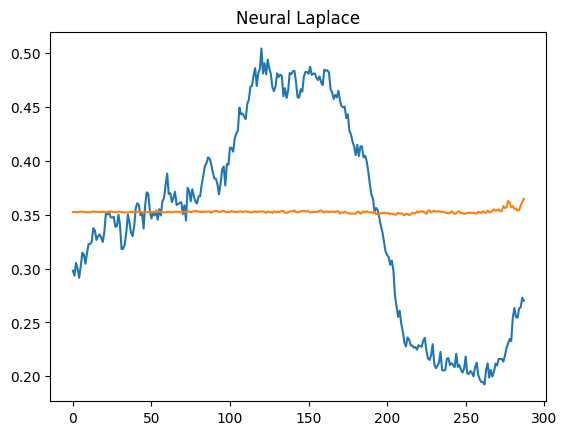

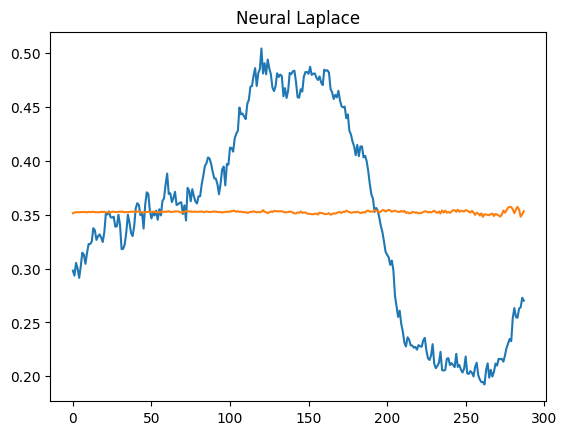

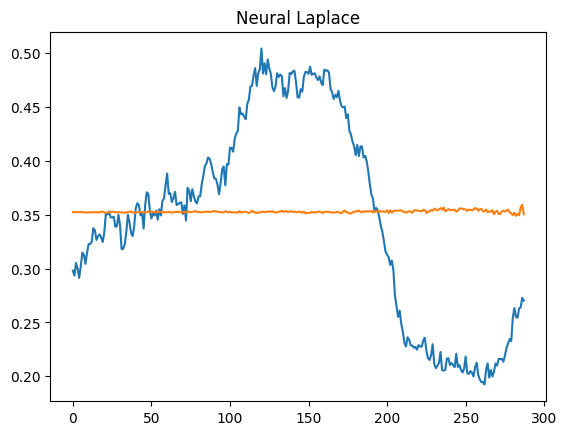

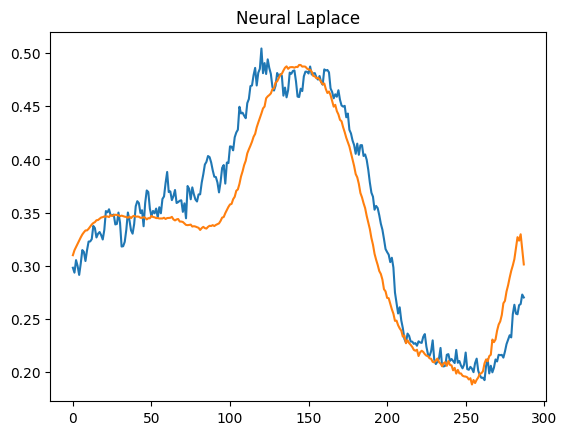

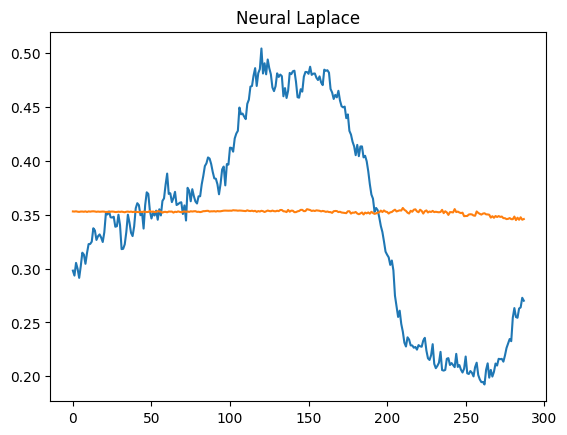

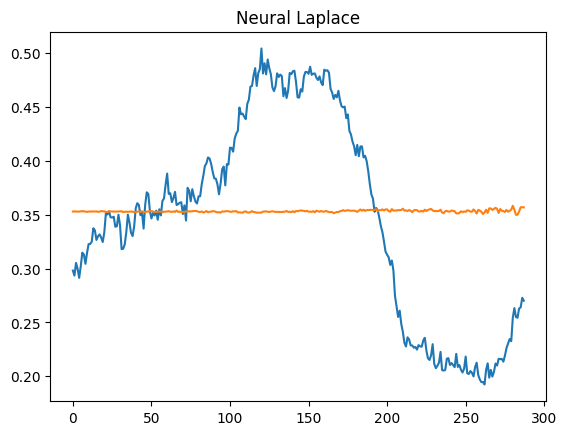

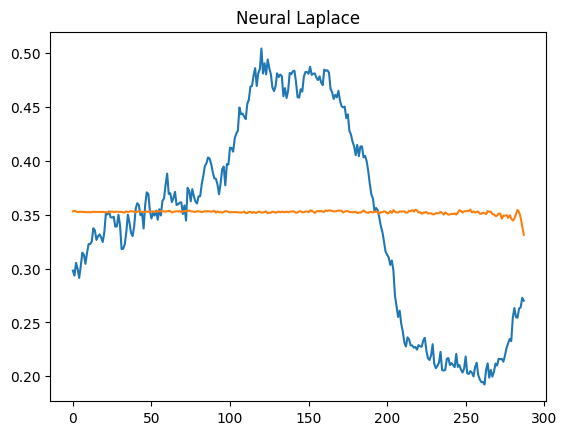

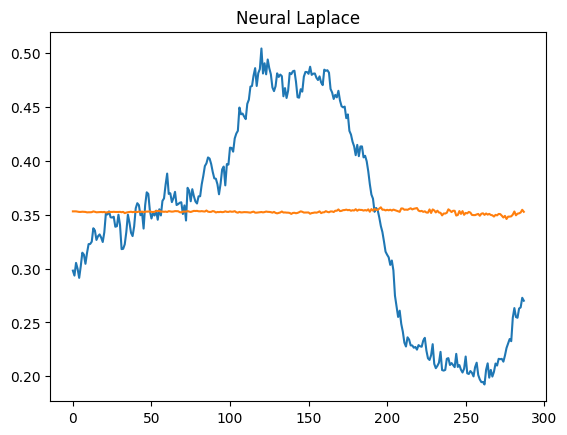

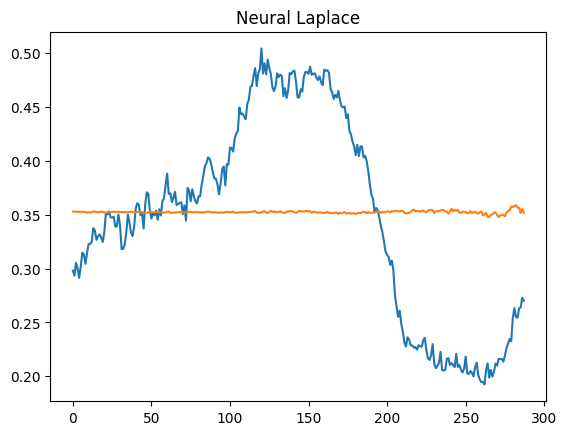

In [3]:
# pth = "results/solete/example_benchmarks-20230906-000810"
# pth = "results/nrel/example_benchmarks-20230817-231811"
# pth = "results/australia/example_benchmarks-20230814-210102"
# pth = "results/mfred/example_benchmarks-20230814-210128"
# pth = "results/mfred/example_benchmarks-20230831-041824"
# pth = "results/mfred/w.fcst_mfred-benchmarks-obs_576-avg_[12, 3, 1]"


# pth = "results/nrel/example_benchmarks-20230830-173619"

# NL with the corresponding frequency
pth = "results/mfred/example_benchmarks-20231012-175829"

# model_names = ['Neural Laplace', 'LSTM', 'MLP']
# model_names = ['Neural Laplace', 'LSTM', 'MLP', 'Persistence']
model_names = ['Neural Laplace']
fcst_features = [0]
all_seed_result = []
all_seed_preds = []
for seed in range(9):
    # if seed == 13:
    #     continue

    with open(f"{pth}-{seed}.pkl", "rb") as f:
        all_result = pickle.load(f)
    test_result = {name: {} for name in model_names}
    test_preds_trajs = {name: {} for name in model_names}
    for avg_terms in all_result:
        result_avg = all_result[avg_terms]
        train_mean = result_avg['train_mean'][fcst_features]
        train_std = result_avg['train_std'][fcst_features]
        num_avg_terms = int(avg_terms.split("_")[-1])
        for name in model_names:
            model_results = result_avg[name]
            # print(seed)
            # print(num_avg_terms)
            # print(name)
            # num = sum(p.numel() for p in model_results["model_state_dict"].values())
            # print(num)
            # print(np.sqrt(model_results["train_losses"][:5]))
            assert len(fcst_features) == model_results["test_preds"].shape[-1]
            test_preds = model_results["test_preds"] * train_std.cpu().numpy(
            ) + train_mean.cpu().numpy()
            test_trajs = model_results["test_trajs"] * train_std.cpu().numpy(
            ) + train_mean.cpu().numpy()
            pred_timesteps = test_trajs.shape[1]
            assert test_preds.shape == test_trajs.shape
            test_result[name][num_avg_terms] = mean_squared_error(
                test_trajs.flatten(), test_preds.flatten(), squared=False)
            test_preds_trajs[name][num_avg_terms] = deepcopy(
                (test_preds, test_trajs))
            if num_avg_terms == 1:
                fig, ax = plt.subplots()
                ax.plot(test_trajs[300,:,0])
                ax.plot(test_preds[300,:,0])
                ax.set_title(name)
    df_test_result = pd.DataFrame(test_result)
    all_seed_preds.append(test_preds_trajs)
    all_seed_result.append(df_test_result)
all_seed_result = pd.concat(all_seed_result, axis=0)
all_seed_result = all_seed_result.groupby(all_seed_result.index).agg(
    ["mean", "std"])
all_seed_result = all_seed_result.sort_index()
avg_terms_list = all_seed_result.index.tolist()
all_seed_result
# with open(f'savings/bench_20_{pth.split("/")[1]}.pickle', 'wb') as handle:
#     pickle.dump(all_seed_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)

mean consistent error

In [6]:
max_avg_terms = max(avg_terms_list)
mce_results = {name: [] for name in model_names}
for seed in range(20):
    preds_trajs_dict = all_seed_preds[seed]
    for name in model_names:
        mce = 0
        for n, avg_terms in enumerate(avg_terms_list):

            if avg_terms < max_avg_terms:
                # print("current avg_terms", avg_terms)
                rest_avg_terms = avg_terms_list[n + 1:]
                (test_preds, test_trajs) = preds_trajs_dict[name][avg_terms]
                for r_avg_terms in rest_avg_terms:
                    (real_avg_preds,
                     real_avg_trajs) = preds_trajs_dict[name][r_avg_terms]

                    # Test trajs are consistent
                    avg_test_trajs = np.split(test_trajs,
                                              test_trajs.shape[1] //
                                              (r_avg_terms // avg_terms),
                                              axis=1)
                    avg_test_trajs = np.stack(
                        [j.mean(axis=1) for j in avg_test_trajs], axis=1)
                    # plt.plot(real_avg_trajs[0])
                    # plt.plot(real_avg_trajs[0])
                    # print(real_avg_trajs[0])
                    # print(avg_test_trajs[0])
                    # assert np.allclose(real_avg_trajs, avg_test_trajs)

                    # calculate predictions
                    avg_test_preds = np.split(test_preds,
                                              test_preds.shape[1] //
                                              (r_avg_terms // avg_terms),
                                              axis=1)
                    avg_test_preds = np.stack(
                        [j.mean(axis=1) for j in avg_test_preds], axis=1)
                    error = (avg_test_preds - real_avg_preds)**2
                    mce += error.mean()
        mce_results[name].append(mce)
mce_results = pd.DataFrame(mce_results)
mce_results.index = [0 for _ in range(20)]
mce_results = mce_results.groupby(mce_results.index).agg(
    ["mean", "std"])
mce_results.index= ["MCE"]
mce_results
# mce_results.to_csv(f"savings/bench_{pth.split('/')[1]}_mce.csv")

Neural Laplace                LSTM                 MLP             
              mean       std      mean       std      mean       std   
MCE       0.001087  0.000188  0.002045  0.000348  0.001432  0.000158  \

      Persistence       
             mean  std  
MCE  1.060256e-15  0.0

## 2. After adjusted

### 2.1 Bottom up

In [7]:
all_bu_results, all_bu_preds = [], []
for seed in range(20):
    preds_trajs_dict = all_seed_preds[seed]
    bu_results = {name + "-BU": {} for name in model_names}
    bu_preds = {name + "-BU": {} for name in model_names}
    for name in model_names:
        for avg_terms in avg_terms_list:
            (test_preds, test_trajs) = preds_trajs_dict[name][1]
            # Test trajs are consistent
            avg_test_trajs = np.split(test_trajs,
                                      test_trajs.shape[1] // avg_terms,
                                      axis=1)
            avg_test_trajs = np.stack([j.mean(axis=1) for j in avg_test_trajs],
                                      axis=1)

            # calculate predictions
            avg_test_preds = np.split(test_preds,
                                      test_preds.shape[1] // avg_terms,
                                      axis=1)
            avg_test_preds = np.stack([j.mean(axis=1) for j in avg_test_preds],
                                      axis=1)
            bu_results[name + "-BU"][avg_terms] = mean_squared_error(
                avg_test_trajs.flatten(),
                avg_test_preds.flatten(),
                squared=False)
            bu_preds[name + "-BU"][avg_terms] = (avg_test_preds,avg_test_trajs
                                                 )

            # if avg_terms == 3:
            # fig, ax = plt.subplots()
            # ax.plot(avg_test_trajs[0,:,0])
            # ax.plot(avg_test_preds[0,:,0])

    bu_results = pd.DataFrame(bu_results)
    all_bu_results.append(bu_results)
    all_bu_preds.append(bu_preds)
all_bu_results = pd.concat(all_bu_results, axis=0)
all_bu_results = all_bu_results.groupby(all_bu_results.index).agg(
    ["mean", "std"])
all_bu_results = all_bu_results.sort_index()
all_bu_results
with open(f'savings/bench_bu_20_{pth.split("/")[1]}.pickle', 'wb') as handle:
    pickle.dump(all_bu_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)
# all_bu_results.to_csv("savings/benchmark_bu.csv")


### 2.2 Optimized

Athanasopoulos, George, et al. "Forecasting with temporal hierarchies." European Journal of Operational Research 262.1 (2017): 60-74.

In [8]:
from scipy.linalg import block_diag

S = [
    block_diag(*[[1.0 / s for _ in range(s)]
                 for _ in range(pred_timesteps // s)]) for s in avg_terms_list
]
S.reverse()
S = np.concatenate(S)
S = S @ np.linalg.inv(S.T @ S) @ S.T

all_opt_results, all_opt_preds = [], []
for seed in range(20):
    preds_trajs_dict = all_seed_preds[seed]
    opt_results = {name + "-OPT": {} for name in model_names}
    opt_preds = {name + "-OPT": {} for name in model_names}
    for name in model_names:
        preds_vec, trajs_vec, pred_steps = [], [], []
        for avg_terms in avg_terms_list[::-1]:
            (test_preds, test_trajs) = preds_trajs_dict[name][avg_terms]
            preds_vec.append(test_preds.copy())
            trajs_vec.append(test_trajs.copy())
        preds_vec = np.concatenate(preds_vec, axis=1)
        # preds_vec = preds_vec.transpose(1, 0, 2)
        adjusted_preds = np.tensordot(S, preds_vec, axes=[1, 1])
        start = 0
        for i, trajs in enumerate(trajs_vec):
            steps = trajs.shape[1]
            opt_results[name +
                        "-OPT"][avg_terms_list[::-1][i]] = mean_squared_error(
                            trajs.flatten(),
                            adjusted_preds[start:start + steps,
                                           ...].transpose(1, 0, 2).flatten(),
                            squared=False)
            opt_preds[name + "-OPT"][avg_terms_list[::-1][i]] = (
                adjusted_preds[start:start + steps, ...].transpose(1, 0,
                                                                   2), trajs)
            # if i == 0:
            #     fig, ax = plt.subplots()
            #     ax.plot(trajs[0].flatten())
            #     ax.plot(adjusted_preds[start:start + steps, 0, :].flatten())
            #     print(adjusted_preds[start:start + steps, 0, :].flatten())
            start += steps

    opt_results = pd.DataFrame(opt_results)
    all_opt_results.append(opt_results)
    all_opt_preds.append(opt_preds)

all_opt_results = pd.concat(all_opt_results, axis=0)
all_opt_results = all_opt_results.groupby(all_opt_results.index).agg(
    ["mean", "std"])
all_opt_results = all_opt_results.sort_index()
# all_opt_results.to_csv("savings/benchmark_opt.csv")
with open(f'savings/bench_opt_20_{pth.split("/")[1]}.pickle', 'wb') as handle:
    pickle.dump(all_opt_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)
all_opt_results

Neural Laplace-OPT            LSTM-OPT             MLP-OPT             
                 mean       std      mean       std      mean       std   
1            0.035529  0.001010  0.036327  0.001015  0.033945  0.000599  \
3            0.035097  0.001021  0.035893  0.001026  0.033490  0.000610   
12           0.034149  0.001034  0.035037  0.001044  0.032614  0.000625   

   Persistence-OPT       
              mean  std  
1         0.036978  0.0  
3         0.036159  0.0  
12        0.034793  0.0

mean consistence error

In [ ]:
max_avg_terms = max(avg_terms_list)
mce_results = {name: [] for name in model_names}
for seed in range(3):
    preds_trajs_dict = all_opt_preds[seed]
    for name in model_names:
        mce = 0
        for n, avg_terms in enumerate(avg_terms_list):

            if avg_terms < max_avg_terms:
                # print("current avg_terms", avg_terms)
                rest_avg_terms = avg_terms_list[n + 1:]
                (test_preds, test_trajs) = preds_trajs_dict[name + "-OPT"][avg_terms]
                for r_avg_terms in rest_avg_terms:
                    (real_avg_preds,
                     real_avg_trajs) = preds_trajs_dict[name + "-OPT"][r_avg_terms]

                    # Test trajs are consistent
                    avg_test_trajs = np.split(test_trajs,
                                              test_trajs.shape[1] //
                                              (r_avg_terms // avg_terms),
                                              axis=1)
                    avg_test_trajs = np.stack(
                        [j.mean(axis=1) for j in avg_test_trajs], axis=1)
                    # assert np.allclose(real_avg_trajs, avg_test_trajs)

                    # calculate predictions
                    avg_test_preds = np.split(test_preds,
                                              test_preds.shape[1] //
                                              (r_avg_terms // avg_terms),
                                              axis=1)
                    avg_test_preds = np.stack(
                        [j.mean(axis=1) for j in avg_test_preds], axis=1)
                    error = (avg_test_preds - real_avg_preds)**2
                    mce += error.mean()
        mce_results[name].append(mce)
mce_results = pd.DataFrame(mce_results)
mce_results.index.name = "seed"
mce_results.mean(axis=0)

# Hierarchical NL

## 1. No adjusts

In [15]:
import pickle
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd

# pth = "results/mfred/dnnFE_addloss_mfred-obs_576-hnl-dnn-sterms_[12, 3, 1]-latent_16-shared_encoderTrue-pass_rawFalse-wd_0.0"

# RNN
# pth = "results/mfred/example-20230819-171706"
# pth = "results/nrel/example-20230819-070441"
# pth = "results/solete/example-20230905-183455"


# DNN
# pth = "results/nrel/example-20230818-023308"
# pth = "results/australia/example-20230815-044201"
# pth = "results/mfred/example-20230901-184707"
pth = "results/mfred/example-20230815-052223"
# pth = "results/nwf_dnnFE_addloss_mfred-obs_576-hnl-dnn-sterms_[12, 3, 1]-latent_16-shared_encoderFalse-pass_rawTrue-wd_0.0"
# pth = "results/addloss_mfred-obs_576-hnl-dnn-sterms_[12, 3, 1]-latent_8-shared_encoderTrue-pass_rawTrue"
# pth = "results/debug_mpmfred-obs_576-hnl-dnn-sterms_[12, 3, 1]-latent_32-shared_encoderFalse-pass_rawFalse"
all_seed_result = []
all_seed_preds = []
fcst_features = [0]
for seed in range(20):
    with open(f"{pth}-{seed}.pkl", "rb") as f:
        result = pickle.load(f)
        avg_terms_list = result["model_hyperparams"]["avg_terms_list"]
        # print(result["model_hyperparams"]["encoder"])
        train_mean = result["train_mean"][fcst_features].detach().cpu().numpy()
        train_std = result["train_std"][fcst_features].detach().cpu().numpy()

        model = result["Hierarchical NL"]
        # avg_terms_list = result["avg_terms_list"]
        # print(result["train_mean"])
        # print(result["train_std"])
        test_label = model["test_trajs"]
        test_preds = model["test_preds"]
        test_label = test_label
        test_label = test_label * train_std + train_mean
        pred_timesteps = test_label.shape[1]

    avg_test_label, avg_test_preds, rmse = {}, {}, {}
    for i, avg_terms in enumerate(avg_terms_list):
        temp = np.split(test_label, test_label.shape[1] // avg_terms, axis=1)
        temp = np.stack([j.mean(axis=1) for j in temp], axis=1)
        avg_test_label[avg_terms] = temp
        # avg_test_preds[avg_terms] = (test_preds[i].detach().cpu().numpy(
        # ), temp)
        avg_test_preds[avg_terms] = (
            test_preds[i].detach().cpu().numpy() * train_std + train_mean,
            temp)

        # print(avg_test_preds[avg_terms][0].flatten())
        rmse[avg_terms] = [
            mean_squared_error(temp.flatten(),
                               avg_test_preds[avg_terms][0].flatten(),
                               squared=False)
        ]
        # fig, ax = plt.subplots()
        # ax.plot(temp[0,:,0])
        # ax.plot(avg_test_preds[avg_terms][0][0,:,0])
    rmse = pd.DataFrame(rmse).transpose()
    all_seed_result.append(rmse)
    all_seed_preds.append(avg_test_preds)
all_seed_result = pd.concat(all_seed_result, axis=0)
all_seed_result = all_seed_result.groupby(all_seed_result.index).agg(
    ["mean", "std"])
avg_terms_list = all_seed_result.index.tolist()
all_seed_result = all_seed_result.rename(columns={0: "Hierarchical NL"})
all_seed_result

# with open(f'savings/proposed_20_{pth.split("/")[1]}.pickle', 'wb') as handle:
#     pickle.dump(all_seed_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)

Hierarchical NL          
              mean       std
1         0.034614  0.000855
3         0.033938  0.000822
12        0.033923  0.000729

mean consistence error

In [8]:
max_avg_terms = max(avg_terms_list)
mce_results = {}
for seed in range(20):
    preds_trajs_dict = all_seed_preds[seed]
    mce = 0
    for n, avg_terms in enumerate(avg_terms_list):

        if avg_terms < max_avg_terms:
            # print("current avg_terms", avg_terms)
            rest_avg_terms = avg_terms_list[n + 1:]
            test_preds, _ = preds_trajs_dict[avg_terms]
            for r_avg_terms in rest_avg_terms:
                real_avg_preds, _ = preds_trajs_dict[r_avg_terms]

                # # Test trajs are consistent
                # avg_test_trajs = np.split(test_trajs,
                #                           test_trajs.shape[1] //
                #                           (r_avg_terms // avg_terms),
                #                           axis=1)
                # avg_test_trajs = np.stack(
                #     [j.mean(axis=1) for j in avg_test_trajs], axis=1)
                # assert np.allclose(real_avg_trajs, avg_test_trajs)

                # calculate predictions
                avg_test_preds = np.split(test_preds,
                                          test_preds.shape[1] //
                                          (r_avg_terms // avg_terms),
                                          axis=1)
                avg_test_preds = np.stack(
                    [j.mean(axis=1) for j in avg_test_preds], axis=1)
                error = (avg_test_preds - real_avg_preds)**2
                mce += error.mean()
    mce_results[seed] = [mce]
mce_results = pd.DataFrame(mce_results)
mce_results.index.name = "seed"
mce_results = mce_results.transpose()
mce_results.columns=["Hierarchical NL"]
mce_results.index = [0 for _ in range(20)]
mce_results = mce_results.groupby(mce_results.index).agg(
    ["mean", "std"])
mce_results.index= ["MCE"]
mce_results
# hnl = pd.concat([all_seed_result, mce_results])
# benchmarks = pd.read_csv("savings/benchmark_raw.csv", index_col=0, header=[0,1])
# benchmarks.index = hnl.index
# all_results = pd.concat([benchmarks, hnl], axis=1)
# print(all_results)
# mce_results.to_csv(f"savings/proposed_{pth.split('/')[1]}_mce.csv")

Hierarchical NL          
               mean       std
MCE        0.059173  0.009602

## 2. After adjusted

### 2.1 BU

In [ ]:
all_bu_results = []
for seed in range(3):
    preds_trajs_dict = all_seed_preds[seed]
    bu_results = {}

    for avg_terms in avg_terms_list:
        (test_preds, test_trajs) = preds_trajs_dict[1]
        # Test trajs are consistent
        avg_test_trajs = np.split(test_trajs,
                                    test_trajs.shape[1] // avg_terms,
                                    axis=1)
        avg_test_trajs = np.stack([j.mean(axis=1) for j in avg_test_trajs],
                                    axis=1)

        # calculate predictions
        avg_test_preds = np.split(test_preds,
                                    test_preds.shape[1] // avg_terms,
                                    axis=1)
        avg_test_preds = np.stack([j.mean(axis=1) for j in avg_test_preds],
                                    axis=1)
        bu_results[avg_terms] = [mean_squared_error(
            avg_test_trajs.flatten(),
            avg_test_preds.flatten(),
            squared=False)]
            # if avg_terms == 3:
            # fig, ax = plt.subplots()
            # ax.plot(avg_test_trajs[0,:,0])
            # ax.plot(avg_test_preds[0,:,0])
            
    bu_results = pd.DataFrame(bu_results)
    all_bu_results.append(bu_results)
all_bu_results = pd.concat(all_bu_results, axis=0)
all_bu_results = all_bu_results.groupby(all_bu_results.index).agg(
    ["mean", "std"])
all_bu_results = all_bu_results.sort_index()
all_bu_results

In [ ]:
from scipy.linalg import block_diag

S = [
    block_diag(*[[1.0 / s for _ in range(s)] for _ in range(pred_timesteps // s)])
    for s in avg_terms_list
]
S.reverse()
S = np.concatenate(S)
S = S @ np.linalg.inv(S.T @ S) @ S.T

all_opt_results, all_opt_preds = [], []
avg_terms_list.sort(reverse=True)
for seed in range(3):
    preds_trajs_dict = all_seed_preds[seed]
    opt_results = {}
    preds_vec, trajs_vec, pred_steps = [], [], []
    for avg_terms in avg_terms_list:
        (test_preds, test_trajs) = preds_trajs_dict[avg_terms]
        preds_vec.append(test_preds.copy())
        trajs_vec.append(test_trajs.copy())
    preds_vec = np.concatenate(preds_vec, axis=1)
    # preds_vec = preds_vec.transpose(1, 0, 2)
    adjusted_preds = np.tensordot(S, preds_vec, axes=[1, 1])
    start = 0
    for i, trajs in enumerate(trajs_vec):
        steps = trajs.shape[1]
        opt_results[avg_terms_list[i]] = [mean_squared_error(
            trajs.flatten(),
            adjusted_preds[start:start + steps, ...].transpose(1,0,2).flatten(),
            squared=False)]
        # if i == 0:
        #     fig, ax = plt.subplots()
        #     ax.plot(trajs[0].flatten())
        #     ax.plot(adjusted_preds[start:start + steps, 0, :].flatten())
        #     print(adjusted_preds[start:start + steps, 0, :].flatten())
        start += steps

    opt_results = pd.DataFrame(opt_results)
    all_opt_results.append(opt_results)

all_opt_results = pd.concat(all_opt_results, axis=0)
all_opt_results = all_opt_results.groupby(all_opt_results.index).agg(
    ["mean", "std"])
all_opt_results = all_opt_results.sort_index(axis=1)
all_opt_results

# Visualize

576
288
[0, 145, 578]
[145, 433, 1153]
(1, 1)
encode_obs_time: False
encode_obs_time: False
encode_obs_time: False
include s recon terms: True
include s recon terms: True
include s recon terms: True


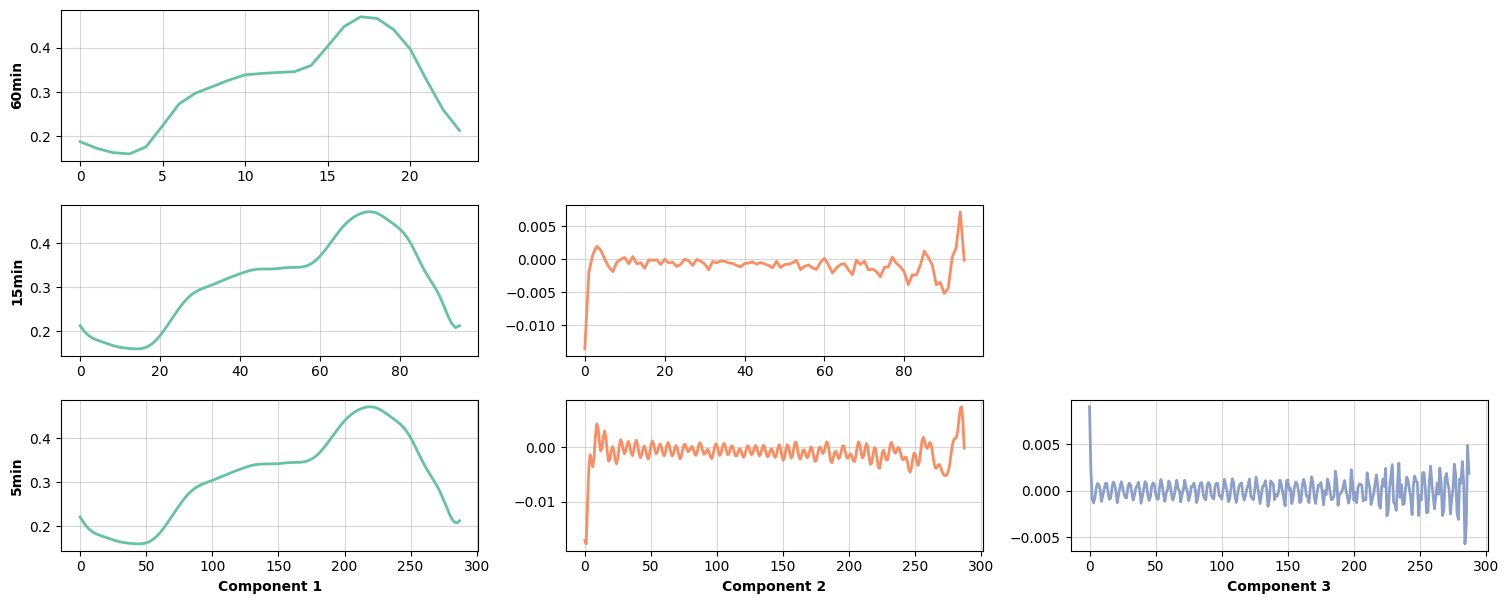

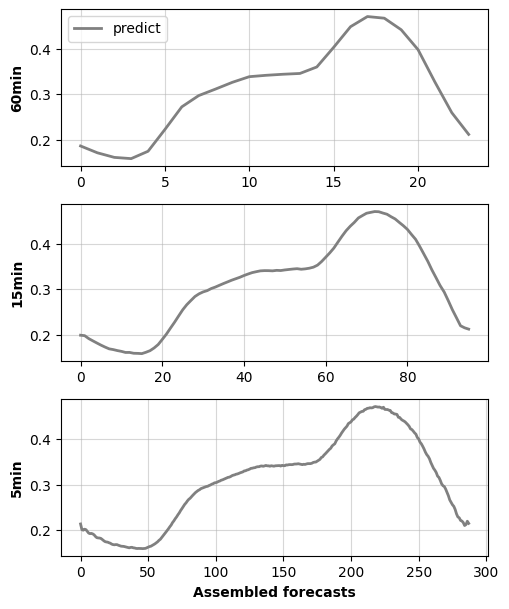

In [30]:
seed = 13
batch_n = 7
# 13, 7
# sample_choose = 93
rand_seed = np.random.randint(0,1000)
sample_choose = np.random.permutation(128)[10]
# pth = "results/solete/example-20230819-044147"
# pth = "results/nrel/example-20230818-023308"
# pth = "results/australia/example-20230815-044201"
# pth = "results/mfred/example-20230815-052223"
pth = "results/mfred/example-20230901-184707"
# pth = "results/nrel/example-20230819-070441"

with open(f"{pth}-{seed}.pkl", "rb") as f:
    result = pickle.load(f)
    model_hyperparams = result["model_hyperparams"]
    data_params = result["data_params"]
    model_state_dict = result["Hierarchical NL"]["model_state_dict"]
from model import GeneralHNL
from dataset import generate_data_set, setup_seed

setup_seed(rand_seed)

(input_dim, output_dim, sample_rate, t, dltrain, dlval, dltest,
 input_timesteps, output_timesteps, train_mean, train_std,
 feature) = generate_data_set(**data_params)
m = GeneralHNL(**model_hyperparams).to(data_params["device"])
m.model.load_state_dict(model_state_dict)

train_mean, train_std = train_mean.cpu().numpy()[
    feature["fcst_feature"]], train_std.cpu().numpy()[feature["fcst_feature"]]
count = 0
for batch in dltest:
    if count == batch_n:
        break

    count += 1

labels = []
for avg_terms in [12, 3, 1]:
    data_to_predict = batch["data_to_predict"].transpose(1, 2)
    data_to_predict = torch.nn.functional.avg_pool1d(data_to_predict,
                                                     avg_terms, avg_terms)
    data_to_predict = data_to_predict.transpose(1, 2)
    labels.append(data_to_predict.detach().cpu().numpy())

all_decomp_fcsts, _ = m.model.decompose_predcit(batch["observed_data"],
                                                batch["available_forecasts"],
                                                batch["observed_tp"],
                                                batch["tp_to_predict"])

fig, axs = plt.subplots(3, 3, figsize=[15, 6])
fig2, axs2 = plt.subplots(3, figsize=[5, 6])
for i in range(len(all_decomp_fcsts)):
    sub_comps = all_decomp_fcsts[i]
    # print(len(sub_comps))
    fcsts = []
    for j in range(len(sub_comps)):
        comps = sub_comps[j]
        # print(comps)
        comps_plt = comps[sample_choose].squeeze(
        ) * train_std + train_mean if j == 0 else comps[sample_choose].squeeze(
        ) * train_std
        comps_plt = np.where(comps_plt > 16, 16, comps_plt)

        axs[i, j].plot(comps_plt, lw=2, c=plt.get_cmap("Set2").colors[j])
        axs[i, j].grid(alpha=0.5)
        axs[i, j].set_axisbelow(True)
        axs[i, j].set_axisbelow(True)
        if j + 1 >= 2:
            fcsts.append(comps[sample_choose].squeeze())
        else:
            fcsts.append(comps[sample_choose].squeeze())

    plt_fcst = np.sum(fcsts, axis=0) * train_std + train_mean
    plt_fcst = np.where(plt_fcst < 0, 0, plt_fcst)
    plt_fcst = np.where(plt_fcst > 16, 16, plt_fcst)
    axs2[i].plot(plt_fcst, lw=2, c="grey", label="predict")
    # axs2[i].plot(labels[i][sample_choose] * train_std + train_mean,
    #              lw=2,
    #              c="grey",
    #              ls="--",
    #              label="real")
    axs2[i].grid(alpha=0.5)

    axs2[i].set_axisbelow(True)

fig.tight_layout()
fig2.tight_layout()
fig.delaxes(axs[0, 1])
fig.delaxes(axs[0, 2])
fig.delaxes(axs[1, 2])

axs2[-1].set_xlabel("Assembled forecasts", fontweight="bold")
axs[-1, 0].set_xlabel("Component 1", fontweight="bold")
axs[-1, 1].set_xlabel("Component 2", fontweight="bold")
axs[-1, 2].set_xlabel("Component 3", fontweight="bold")
axs[0, 0].set_ylabel("60min", fontweight="bold")
axs[1, 0].set_ylabel("15min", fontweight="bold")
axs[2, 0].set_ylabel("5min", fontweight="bold")
axs2[0].set_ylabel("60min", fontweight="bold")
axs2[1].set_ylabel("15min", fontweight="bold")
axs2[2].set_ylabel("5min", fontweight="bold")
axs2[0].legend()

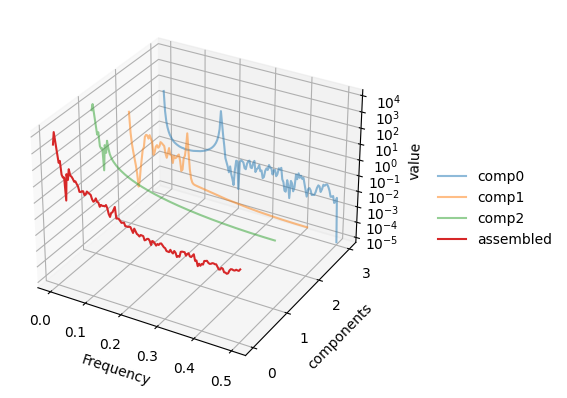

In [79]:
fig, axs = plt.subplots(subplot_kw=dict(projection='3d'))
# xf, yf = make_rfft(labels.flatten(), sample_rate=sample_rate.numpy())
# axs.plot(xf, yf, label="real")
yticks= [3, 2, 1, 0]

for i in range(all_decomp_fcsts.shape[0]):
    xf, yf = make_rfft(all_decomp_fcsts[-i-1].flatten(), sample_rate=sample_rate.numpy())
    # print(xf)
    axs.plot(xf, [4-(i+1) for _ in range(len(xf))], np.log(yf), label=f"comp{i}", alpha=0.5)
    # axs.set_yscale('log')
    axs.legend()
xf, yf = make_rfft(all_decomp_fcsts.sum(axis=0).flatten(), sample_rate=sample_rate.numpy())
axs.plot(xf,[0 for _ in range(len(xf))], np.log(yf), label="assembled")
axs.set(xlabel="Frequency", zlabel="value", ylabel="components")
axs.set_yticks(yticks)
axs.legend(loc="best",frameon=False, bbox_to_anchor=(1.5,0.6))
axs.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
axs.zaxis.set_major_locator(mticker.MaxNLocator(integer=True))
axs.zaxis.set_minor_locator(MultipleLocator(1000))
fig.savefig(f"savings/freqdecomp_{pth.split('/')[1]}.pdf", bbox_inches="tight")


    Neural Laplace                 LSTM                 MLP             
              mean       std       mean       std      mean       std   
MCE      21.396072  9.800803  13.937465  5.824581  8.514755  2.555646  \

    Persistence      Hierarchical NL           
           mean  std            mean      std  
MCE     2.16996  0.0        0.666381  0.48446  
Index(['Hierarchical NL', 'LSTM', 'MLP', 'Neural Laplace', 'Persistence'], dtype='object')
Index(['Neural Laplace', 'LSTM', 'MLP', 'Persistence', 'Hierarchical NL'], dtype='object')


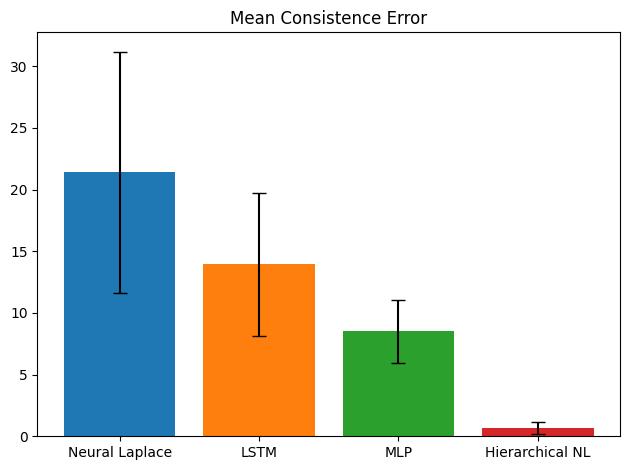

In [3]:
dataset = "nrel"
bench_mce = pd.read_csv(f"savings/bench_{dataset}_mce.csv", index_col=0, header=[0,1])
proposed_mce = pd.read_csv(f"savings/proposed_{dataset}_mce.csv", index_col=0, header=[0,1])
all_df = pd.concat([bench_mce, proposed_mce], axis=1)
print(all_df)
model_names = all_df.columns.levels[0]
print(model_names)
fig, ax= plt.subplots()
raw_df = all_df.swaplevel(1,0,axis=1)
# print(raw_df)
print(raw_df["mean"].iloc[-1,:].index)
xticks = []
count = 0
for i in range(len(model_names)):
    if raw_df["mean"].iloc[-1,:].index[i] == "Persistence":
        continue
    ax.bar(x=count, height=raw_df["mean"].iloc[-1,i], yerr=raw_df["std"].iloc[-1,i],capsize=5)
    xticks.append(raw_df["mean"].iloc[-1,:].index[i])
    count+=1
ax.set_xticks(np.arange(len(xticks)), xticks)
ax.set_title("Mean Consistence Error")
fig.tight_layout()
fig.savefig(f"savings/MCE_{dataset}.pdf", transparent=True, bbox_inches="tight")

     Hierarchical NL      LSTM       MLP  Neural Laplace
MCE         0.000291  0.002045  0.001432        0.001087
     Hierarchical NL       LSTM       MLP  Neural Laplace
MCE         0.666381  13.937465  8.514755       21.396072
[0.66638103]
   Proposed         LSTM          MLP  Neural Laplace dataset
0       0.0   602.461668   391.770103      273.499081    load
1       0.0  1991.515892  1177.760777     3110.786454    wind


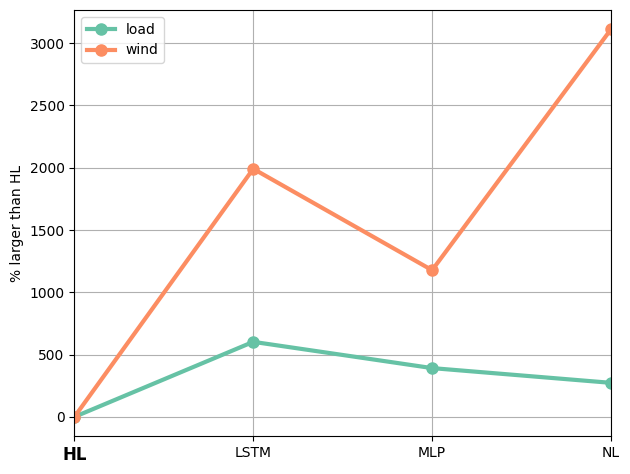

In [35]:
from pandas.plotting import parallel_coordinates
dataset = "nrel"
bench_mce = pd.read_csv(f"savings/bench_{dataset}_mce.csv", index_col=0, header=[0,1])
proposed_mce = pd.read_csv(f"savings/proposed_{dataset}_mce.csv", index_col=0, header=[0,1])
all_wind_df = pd.concat([bench_mce, proposed_mce], axis=1)

dataset = "mfred"
bench_mce = pd.read_csv(f"savings/bench_{dataset}_mce.csv", index_col=0, header=[0,1])
proposed_mce = pd.read_csv(f"savings/proposed_{dataset}_mce.csv", index_col=0, header=[0,1])
all_load_df = pd.concat([bench_mce, proposed_mce], axis=1)

all_wind_df = all_wind_df.stack(level=1).transpose().swaplevel(
    1, 0, axis=1)["mean"]
all_load_df = all_load_df.stack(level=1).transpose().swaplevel(
    1, 0, axis=1)["mean"]

all_load_df = all_load_df.T
all_wind_df = all_wind_df.T
print(all_load_df)
all_wind_df.drop(columns=["Persistence"],inplace=True)
print(all_wind_df)
print(all_wind_df["Hierarchical NL"].values)
all_wind_df /= all_wind_df["Hierarchical NL"].values[0]
all_load_df /= all_load_df["Hierarchical NL"].values[0]
all_wind_df -= 1
all_load_df -= 1
all_df = pd.concat([all_load_df, all_wind_df]) * 100
all_df = all_df.rename(columns={"Hierarchical NL":"Proposed"})
all_df.reset_index(inplace=True, drop=True)
all_df["dataset"] =["load","wind"]
proposed_df = all_df.pop("Proposed")
all_df = pd.concat([proposed_df, all_df], axis=1)
print(all_df)
all_df.columns = ["HL","LSTM","MLP","NL","dataset"]
# all_df
# all_load_df["models"] = all_load_df.index
fig, ax= plt.subplots()
# ax.set_axisbelow(True)
parallel_coordinates(all_df,"dataset",color=plt.get_cmap("Set2").colors,marker="o",lw=3,ms=8,ax=ax,axvlines=False)
ax.legend(loc="best")
# ax.set_title("Mean Consistency Error")
ax.set_ylabel("% larger than HL")
# print(model_names)
# ax.set_xticks(np.arange(len(xticks)), xticks)
# ax.set_title("Mean Consistence Error")
fig.tight_layout()
for i, tick in enumerate(ax.get_xticklabels()):
    if i == 0:
        tick.set_fontweight('bold')
        tick.set_fontsize(12)
fig.savefig(f"savings/mce.pdf", transparent=True, bbox_inches="tight")

      Hierarchical NL      LSTM       MLP  Neural Laplace
load         0.000291  0.002045  0.001432        0.001087
      Hierarchical NL       LSTM       MLP  Neural Laplace
wind         0.666381  13.937465  8.514755       21.396072
[0.66638103]
    HL       LSTM        MLP         NL dataset
0  1.0   7.024617   4.917701   3.734991    load
1  1.0  20.915159  12.777608  32.107865    wind
       HL       LSTM        MLP         NL
load  1.0   7.024617   4.917701   3.734991
wind  1.0  20.915159  12.777608  32.107865


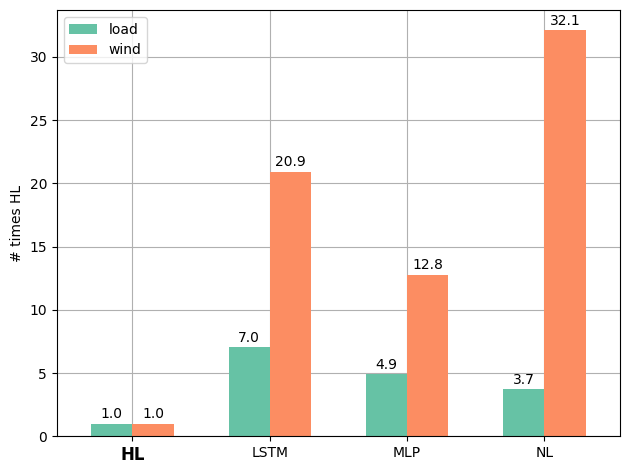

In [56]:
from pandas.plotting import parallel_coordinates
dataset = "nrel"
bench_mce = pd.read_csv(f"savings/bench_{dataset}_mce.csv", index_col=0, header=[0,1])
proposed_mce = pd.read_csv(f"savings/proposed_{dataset}_mce.csv", index_col=0, header=[0,1])
all_wind_df = pd.concat([bench_mce, proposed_mce], axis=1)

dataset = "mfred"
bench_mce = pd.read_csv(f"savings/bench_{dataset}_mce.csv", index_col=0, header=[0,1])
proposed_mce = pd.read_csv(f"savings/proposed_{dataset}_mce.csv", index_col=0, header=[0,1])
all_load_df = pd.concat([bench_mce, proposed_mce], axis=1)

all_wind_df = all_wind_df.stack(level=1).transpose().swaplevel(
    1, 0, axis=1)["mean"]
all_load_df = all_load_df.stack(level=1).transpose().swaplevel(
    1, 0, axis=1)["mean"]

all_load_df = all_load_df.T
all_wind_df = all_wind_df.T
all_load_df.index = ["load"]
all_wind_df.index = ["wind"]
print(all_load_df)
all_wind_df.drop(columns=["Persistence"],inplace=True)
print(all_wind_df)
print(all_wind_df["Hierarchical NL"].values)
all_wind_df /= all_wind_df["Hierarchical NL"].values[0]
all_load_df /= all_load_df["Hierarchical NL"].values[0]
# all_wind_df -= 1
# all_load_df -= 1
all_df = pd.concat([all_load_df, all_wind_df])
all_df = all_df.rename(columns={"Hierarchical NL":"HL","Neural Laplace":"NL"})
all_df.reset_index(inplace=True, drop=True)
all_df["dataset"] =["load","wind"]
proposed_df = all_df.pop("HL")
all_df = pd.concat([proposed_df, all_df], axis=1)
print(all_df)

fig, ax= plt.subplots()
# ax2 = ax.twinx()
all_df.index = ["load","wind"]
all_df.drop(columns=["dataset"],inplace=True)
print(all_df)
all_df.T.plot(kind='bar', ax=ax, color=plt.get_cmap("Set2").colors, width=0.6,rot=0)
# plt_load = all_load_df.T
# plt_wind = all_wind_df.T
# plt_load.plot(kind="bar", ax=ax,position=0)
# plt_wind.plot(kind="bar", ax=ax2,position=1)
# ax.axhline(1,xmin=0, xmax=0.125, color="grey", alpha=0.5)
ax.set_axisbelow(True)
ax.grid()
ax.legend(loc="best")
ax.set_ylabel("# times HL")
rects = ax.patches

# Make some labels.
labels = all_df.values.flatten()

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 0.2, "{:.1f}".format(label), ha="center", va="bottom"
    )
fig.tight_layout()
for i, tick in enumerate(ax.get_xticklabels()):
    if i == 0:
        tick.set_fontweight('bold')
        tick.set_fontsize(12)
fig.savefig(f"savings/mce.pdf", transparent=True, bbox_inches="tight")